In [1]:
import argparse

def args_parser():
    parser = argparse.ArgumentParser()
    # federated arguments
    #RL的训练轮次
    parser.add_argument('--epochs', type=int, default=500, help="rounds of training")
    
    #嵌入向量的训练轮次
    parser.add_argument('--emb_train_epochs', type=int, default=10, help="rounds of training")
    parser.add_argument('--reset_flag', type=int, default=100, help="reset flag")
    #验证RL和Fedavg哪个更好的验证轮次
    parser.add_argument('--validation_epochs', type=int, default=50, help="rounds of training")
    parser.add_argument('--divide', type=str, default='True')
    
    #将训练集分为几份
    parser.add_argument('--divide_num', type=int, default=2, help="divide number")
    
    #有多少个local client
    parser.add_argument('--num_users', type=int, default=100, help="number of users: K")
    parser.add_argument('--k', type=int, default=10, help="k")
    
    #每次选多少个local client参与训练
    parser.add_argument('--frac', type=float, default=0.1, help="the fraction of clients: C")
    parser.add_argument('--train_frac', type=float, default=1, help="the fraction of training: C")
    
    parser.add_argument('--collect_ep', type=int, default=1000, help="rounds of training")
    
    #local client自己本地训练的轮次
    parser.add_argument('--local_ep', type=int, default=20, help="the number of local epochs: E")
    
    #验证环节的local clinet本地训练轮次
    parser.add_argument('--local_validation_ep', type=int, default=10, help="the number of local epochs: E")
    
    #local client本地训练的batchsize
    parser.add_argument('--local_bs', type=int, default=10, help="local batch size: B")
    parser.add_argument('--bs', type=int, default=128, help="test batch size")
    
    #RL的学习率和衰减率
    parser.add_argument('--lr', type=float, default=0.01, help="learning rate (default: 0.01)")
    parser.add_argument('--lr_decay', type=float, default=1, help="lr decay")
    parser.add_argument('--momentum', type=float, default=0.5, help="SGD momentum (default: 0.5)")
    parser.add_argument('--split', type=str, default='user', help="train-test split type, user or sample")

    # model arguments
    
    #使用的client 模型
    parser.add_argument('--model', type=str, default='cnn', help='model name')
    parser.add_argument('--kernel_num', type=int, default=9, help='number of each kind of kernel')
    parser.add_argument('--kernel_sizes', type=str, default='3,4,5',
                        help='comma-separated kernel size to use for convolution')
    parser.add_argument('--norm', type=str, default='batch_norm', help="batch_norm, layer_norm, or None")
    parser.add_argument('--num_filters', type=int, default=32, help="number of filters for conv nets")
    parser.add_argument('--max_pool', type=str, default='True',
                        help="Whether use max pooling rather than strided convolutions")

    # other arguments
    
    #使用的数据集
    parser.add_argument('--dataset', type=str, default='mnist', help="name of dataset")
    
    #数据集的划分是否满足独立同分布
    parser.add_argument('--iid', action='store_true', help='whether i.i.d or not')
    
    #输出的分类个数
    parser.add_argument('--num_classes', type=int, default=10, help="number of classes")
    
    #输入的图片的通道数
    parser.add_argument('--num_channels', type=int, default=1, help="number of channels of imges")
    parser.add_argument('--gpu', type=int, default=-1, help="GPU ID, -1 for CPU")
    parser.add_argument('--stopping_rounds', type=int, default=10, help='rounds of early stopping')
    parser.add_argument('--verbose', action='store_true', help='verbose print')
    parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')
    parser.add_argument('--all_clients', action='store_true', help='aggregation over all clients')
    args = parser.parse_args(args=[])
    return args

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
# Python version: 3.6

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
import random
from torchvision import datasets, transforms
from collections import deque
  
import torch
import torch.nn as nn
import torch.nn.functional as F

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid, mnist_iid_drl_local_divide, cifar_iid_drl_local_divide, mnist_noniid_drl_local_divide
from models.Update import LocalUpdate
from models.Update_divide import LocalUpdate_divide
from models.Nets import MLP, CNNMnist, CNNCifar, CNNCifarEmb, CNNCifarEmbReverse, CNNMnistEmb, CNNMnistEmbReverse
from models.Fed import FedAvg
# from models.test import test_img

# parse args
args = args_parser()
args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: x.repeat(1,1,1))])
    dataset_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('./data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    args.iid = False
    args.divide = False
    #第一组作为drl训练，第二组作为和fedavg对比
    if args.divide:
        if args.iid:
#             print(int(len(dataset_train)/args.divide_num))
#             print(int(len(dataset_train)/args.num_users/args.divide_num))
            dict_users = mnist_iid_drl_local_divide(dataset_train, args.num_users, args.divide_num)
        else:
            dict_users = mnist_noniid_drl_local_divide(dataset_train, args.num_users, args.divide_num)
    else:
        if args.iid:
            dict_users = mnist_iid(dataset_train, args.num_users)
        else:
            dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar)
    args.iid = True
    if args.divide:
        if args.iid:
#             print(int(len(dataset_train)/args.divide_num))
#             print(int(len(dataset_train)/args.num_users/args.divide_num))
            dict_users = cifar_iid_drl_local_divide(dataset_train, args.num_users, args.divide_num)
        else:
            exit('Error: only consider IID setting in CIFAR10')
    else:
        if args.iid:
            dict_users = cifar_iid(dataset_train, args.num_users)
        else:
            exit('Error: only consider IID setting in CIFAR10')
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

# build model
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
print(net_glob)
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

CNNMnist(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [3]:
class MemoryBuffer: # MemoryBuffer类实现的功能：buffer内采样，往buffer里塞（sars）

    def __init__(self, size):
        self.buffer = deque(maxlen=size) #buffer设置为双端队列
        self.maxSize = size
        self.len = 0
        
    def state_reco(self, s):
        s_1 = [i[0] for i in s]
        s_2 = [i[1] for i in s]
        s_3 = [i[2] for i in s]
        return [torch.cat(s_1),torch.cat(s_2),torch.cat(s_3)]

    def sample(self, count):
        """
        samples a random batch from the replay memory buffer
        :param count: batch size
        :return: batch (numpy array)
        """
        batch = []
        count = min(count, self.len)
        batch = random.sample(self.buffer, count) # 随机取样

        s_arr = [arr[0] for arr in batch]
        a_arr = torch.cat([arr[1] for arr in batch])
        r_arr = torch.tensor([arr[2] for arr in batch]).reshape(-1,1)
        s1_arr = [arr[3] for arr in batch]

        return self.state_reco(s_arr), a_arr, r_arr, self.state_reco(s1_arr)

    def len(self):
        return self.len

    def add(self, s, a, r, s1):
        """
        adds a particular transaction in the memory buffer
        :param s: current state
        :param a: action taken
        :param r: reward received
        :param s1: next state
        :return:
        """
        transition = (s,a,r,s1)
        self.len += 1
        if self.len > self.maxSize:
            self.len = self.maxSize
        self.buffer.append(transition)

In [4]:
class Actor(nn.Module):

    def __init__(self, parameter_dim, loss_dim, action_dim, args):
        super(Actor, self).__init__()
        self.args = args
        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim

        self.fc1 = nn.Linear(parameter_dim, action_dim)

        self.fc2 = nn.Linear(action_dim*(int(args.num_users*args.frac*args.train_frac+2)),action_dim)

    def forward(self, parameters, last_loss, last_weight):
        parameter_lst = []
        for i in range(self.action_dim):
            parameter_lst.append(self.fc1(parameters[:,i,:]))
        parameter_layer = torch.cat(parameter_lst,dim=1)
        x = torch.cat([parameter_layer,last_loss, last_weight],dim=1)
        action = F.softmax(self.fc2(x),dim=1)

        return action

class Critic(nn.Module):

    def __init__(self, parameter_dim, loss_dim, action_dim, args):
        super(Critic, self).__init__()
        self.args = args
        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim

        self.fc1 = nn.Linear(parameter_dim,action_dim)

        self.fc2 = nn.Linear(action_dim*(int(args.num_users*args.frac*args.train_frac+3)),1)

    def forward(self, parameters, last_loss, last_weight, action):
        parameter_lst = []
        for i in range(self.action_dim):
            parameter_lst.append(self.fc1(parameters[:,i,:]))
        parameter_layer = torch.cat(parameter_lst,dim=1)
        x = torch.cat([parameter_layer,last_loss, last_weight, action],dim=1)
        q = self.fc2(x)

        return q

In [5]:
GAMMA=0.8
class Trainer:

    def __init__(self, parameter_dim, loss_dim, action_dim, replay_buffer, args):
        self.parameter_dim = parameter_dim
        self.loss_dim = loss_dim
        self.action_dim = action_dim
        self.replay_buffer = replay_buffer
        self.iter = 0
        #self.noise = utils.OrnsteinUhlenbeckActionNoise(self.action_dim)

        self.actor = Actor(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)
        self.target_actor = Actor(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),0.01)

        self.critic = Critic(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)
        self.target_critic = Critic(self.parameter_dim, 
                                 self.loss_dim, 
                                 self.action_dim, args).to(args.device)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),0.01)

        self.hard_update(self.target_actor, self.actor)
        self.hard_update(self.target_critic, self.critic)

    def soft_update(self, target, source, tau):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(
                target_param.data * (1.0 - tau) + param.data * tau
            )
    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
                target_param.data.copy_(param.data)
                
    def get_exploitation_action(self, parameters, last_loss, last_weight):
        action = self.target_actor.forward(parameters, last_loss, last_weight).detach()
        return action.data.numpy()

#     def get_exploration_action(self, state):
#         """
#         gets the action from actor added with exploration noise
#         :param state: state (Numpy array)
#         :return: sampled action (Numpy array)
#         """
#         state = Variable(torch.from_numpy(state))
#         action = self.actor.forward(state).detach()
#         new_action = action.data.numpy() + (self.noise.sample())
#         return new_action

    def optimize(self):
        """
        Samples a random batch from replay memory and performs optimization
        :return:
        """
        s1,a1,r1,s2 = self.replay_buffer.sample(8)

#         s1 = Variable(torch.from_numpy(s1))
#         a1 = Variable(torch.from_numpy(a1))
#         r1 = Variable(torch.from_numpy(r1))
#         s2 = Variable(torch.from_numpy(s2))

        # ---------------------- optimize critic ----------------------
        # Use target actor exploitation policy here for loss evaluation
        # 这里应该是TD的方法
        a2 = self.target_actor.forward(s2[0],s2[1],s2[2]).detach()
        next_val = torch.squeeze(self.target_critic.forward(s2[0],s2[1],s2[2], a2).detach())
        # y_exp = r + gamma*Q'( s2, pi'(s2))
        y_expected = r1 + GAMMA*next_val
        # y_pred = Q( s1, a1)
        y_predicted = torch.squeeze(self.critic.forward(s1[0],s1[1],s1[2], a1))
        # compute critic loss, and update the critic
        loss_critic = F.smooth_l1_loss(y_predicted.float(), y_expected.float())
        self.critic_optimizer.zero_grad()
        loss_critic.backward(retain_graph=True)
        self.critic_optimizer.step()

        # ---------------------- optimize actor ----------------------
        pred_a1 = self.actor.forward(s1[0],s1[1],s1[2])
        loss_actor = -1*torch.sum(self.critic.forward(s1[0],s1[1],s1[2], pred_a1))
        self.actor_optimizer.zero_grad()
        loss_actor.backward(retain_graph=True)
        self.actor_optimizer.step()

        self.soft_update(self.target_actor, self.actor, 0.001)
        self.soft_update(self.target_critic, self.critic, 0.001)

        if self.iter % 1 == 0:
            print('Iteration :', self.iter, ' Loss_actor :', loss_actor.data.numpy(),\
                ' Loss_critic :', loss_critic.data.numpy())
        self.iter += 1

    def save_models(self, episode_count):
        torch.save(self.target_actor.state_dict(), './Models/' + str(episode_count) + '_actor.pt')
        torch.save(self.target_critic.state_dict(), './Models/' + str(episode_count) + '_critic.pt')
        
    def load_models(self, episode):
        self.actor.load_state_dict(torch.load('./Models/' + str(episode) + '_actor.pt'))
        self.critic.load_state_dict(torch.load('./Models/' + str(episode) + '_critic.pt'))
        utils.hard_update(self.target_actor, self.actor)
        utils.hard_update(self.target_critic, self.critic)

In [6]:
paramter = []
for i in w_glob.keys():
    paramter.append(w_glob[i].reshape(1,-1))

parameter_dim = torch.cat(paramter,axis=1).shape[1]
loss_dim = max(int(args.frac * args.num_users * args.train_frac), 1)
action_dim = max(int(args.frac * args.num_users * args.train_frac), 1)
# for i in w_glob.keys():
#     print(i)

# print(len(w_glob['conv1.weight'].reshape(1,-1).numpy()[0]))
# print(len(w_glob['conv1.bias'].reshape(1,-1).numpy()[0]))
# print(len(w_glob['conv2.weight'].reshape(1,-1).numpy()[0]))
# print(len(w_glob['conv2.bias'].reshape(1,-1).numpy()[0]))
# print(len(w_glob['fc1.weight'].reshape(1,-1).numpy()[0]))
# print(len(w_glob['fc1.bias'].reshape(1,-1).numpy()[0]))
# print(len(w_glob['fc2.weight'].reshape(1,-1).numpy()[0]))
# print(len(w_glob['fc2.bias'].reshape(1,-1).numpy()[0]))
# print(len(w_glob['fc3.weight'].reshape(1,-1).numpy()[0]))
# print(len(w_glob['fc3.bias'].reshape(1,-1).numpy()[0]))

# testcnn = CNNCifarEmb(len(w_glob['conv1.weight'].reshape(1,-1).numpy()[0]))
# testcnn.forward(w_glob['conv1.weight'])

In [7]:
layer_dict = {}
layer_name = []
count = 0
for name in w_glob.keys():
    if count % 2 == 0:
        layer_name.append(name.split('.',1)[0])
    count += 1
    
for i in layer_name:
#     layer_dict[i] = CNNCifarEmb(torch.cat([w_glob[i+'.weight'].reshape(1,-1), w_glob[i+'.bias'].reshape(1,-1)], 1).numel())
    layer_dict[i] = CNNMnistEmb(torch.cat([w_glob[i+'.weight'].reshape(1,-1), w_glob[i+'.bias'].reshape(1,-1)], 1).numel())
# emb_reverse = CNNCifarEmbReverse(args)
emb_reverse = CNNMnistEmbReverse(args)
# print(w_glob[i+'.weight'].reshape(1,-1).numpy()[0])

# print(w_glob[i+'.bias'].numpy())

optimizer = torch.optim.Adam([
    {'params':layer_dict[layer_name[0]].parameters()},
    {'params':layer_dict[layer_name[1]].parameters()},
    {'params':layer_dict[layer_name[2]].parameters()},
    {'params':layer_dict[layer_name[3]].parameters()},
#     {'params':layer_dict[layer_name[4]].parameters()},
    {'params':emb_reverse.parameters()}
] ,0.01)

for iter in range(args.emb_train_epochs):
    idxs_users = np.random.choice(range(args.num_users), 20, replace=False)
    
    for idx in idxs_users:
#         local = LocalUpdate_divide(args=args, dataset=dataset_train, idxs=dict_users[0][idx])
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
#         w, loss, loss_list = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        for i in layer_name:
            if i == 'conv1':
                emb_feature = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1).to(args.device))
            else:
                emb_feature += layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1).to(args.device))
        avg_emb_feature = emb_feature/5
        transform_w = emb_reverse.forward(avg_emb_feature)
        loss_w = [sum((w[i].reshape(1,-1) - transform_w[i].reshape(1,-1)) ** 2) for i in w_glob.keys()]
        loss_avg = 0
        loss_check_dict = {}
        for i in range(len(loss_w)):
            loss_avg += sum(loss_w[i])/len(loss_w[i])
            loss_check_dict[len(loss_w[i])] = loss_w[i]
            if loss_avg.item() > 3.0:
                print('len:{},w:{}'.format(len(loss_w[i]), loss_check_dict[len(loss_w[i])]))
                print('loss_sum:', loss_avg)
                print('\n***************')
        optimizer.zero_grad()
        loss_avg.backward(retain_graph=True)
        optimizer.step()
        print('epoch:{}, loss_avg:{}'.format(iter, loss_avg))

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch:0, loss_avg:0.8267110586166382
epoch:0, loss_avg:1.0634058713912964
epoch:0, loss_avg:0.8738073110580444
epoch:0, loss_avg:0.498268723487854
epoch:0, loss_avg:0.642773449420929
epoch:0, loss_avg:0.49711257219314575
epoch:0, loss_avg:0.9371582269668579
epoch:0, loss_avg:0.5596201419830322
epoch:0, loss_avg:0.44442808628082275
epoch:0, loss_avg:0.41640084981918335
epoch:0, loss_avg:0.44640591740608215
epoch:0, loss_avg:0.5192306041717529
epoch:0, loss_avg:0.3565357029438019
epoch:0, loss_avg:0.3365165591239929
epoch:0, loss_avg:0.1825781911611557
epoch:0, loss_avg:0.3818092346191406
epoch:0, loss_avg:0.28852957487106323
epoch:0, loss_avg:0.46920353174209595
epoch:0, loss_avg:0.3629680275917053
epoch:0, loss_avg:0.32713016867637634
epoch:1, loss_avg:0.4226560592651367
epoch:1, loss_avg:0.6488065719604492
epoch:1, loss_avg:0.3188665211200714
epoch:1, loss_avg:0.3069033622741699
epoch:1, loss_avg:0.26423177123069763
epoch:1, loss_avg:0.31888166069984436
epoch:1, loss_avg:0.37041932344

In [11]:
replay_buffer = MemoryBuffer(500)
trainer = Trainer(100, loss_dim, action_dim, replay_buffer, args)

In [12]:
def FedPareto(w,action):
    w_avg = copy.deepcopy(w[0])
    for k in w_avg.keys():
        for i in range(0, len(w)):
            if i==0:
                w_avg[k] = action[i] * w[i][k]
            else:
                w_avg[k] += action[i] * w[i][k]
    return w_avg

In [13]:
# training
loss_train = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []
m = max(int(args.frac * args.num_users * args.train_frac), 1)
loss_save = []
# trainer = torch.load('rl_{}_{}_{}_clientnumber{}_localep{}.pt'.format(args.dataset, args.epochs, args.model, m, args.local_ep))
# trainer = torch.load('rl_mnist.pt')

last_replay_data = []
for iter in range(args.epochs):
    if iter==0:
        random_n = 0
        n_weight = []
        while random_n<args.num_users*args.frac*args.train_frac:
            n_weight.append(random.random()) # 随机初始化参数
            random_n+=1
        action = F.softmax(torch.tensor(n_weight))
        net_fedavg = copy.deepcopy(net_glob).to(args.device)
    
    if iter % args.reset_flag == 0:
        if args.model == 'cnn' and args.dataset == 'cifar':
            net_glob = CNNCifar(args=args).to(args.device)
        elif args.model == 'cnn' and args.dataset == 'mnist':
            net_glob = CNNMnist(args=args).to(args.device)
        elif args.model == 'mlp':
            len_in = 1
            for x in img_size:
                len_in *= x
            net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
        else:
            exit('Error: unrecognized model')
        net_fedavg = copy.deepcopy(net_glob).to(args.device)
    
    loss_locals = []
    w_locals = []
#     m = max(int(args.frac * args.num_users), 1)
    m = max(int(args.frac * args.num_users * args.train_frac), 1)
#     m = max(int(args.frac * args.num_users * args.train_frac * args.k * iter/args.epochs), 1)
#     m = min(max(int(args.frac * args.num_users * args.train_frac * iter), 1), 10)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    p_emb_collect = []
    w_fedavg_list = []
    loss_fedavg_list = []
    loss_total_rl_list = []
    loss_total_fedavg_list = []
    for idx in idxs_users:
#         local = LocalUpdate_divide(args=args, dataset=dataset_train, idxs=dict_users[0][idx])
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
#         w, loss, loss_epoch_rl_list = local.train(net=copy.deepcopy(net_glob).to(args.device))
#         w_fedavg, loss_fedavg, loss_epoch_fedavg_list = local.train(net=copy.deepcopy(net_fedavg).to(args.device))
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_fedavg, loss_fedavg = local.train(net=copy.deepcopy(net_fedavg).to(args.device))
#         loss_total_rl_list += loss_epoch_rl_list
#         loss_total_fedavg_list += loss_epoch_fedavg_list
        for i in layer_name:
            if i == 'conv1':
                emb_feature = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
            else:
                emb_feature += layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
        avg_emb_feature = emb_feature/4
        ############ 储存参数 ##############
        p_emb_collect.append(avg_emb_feature)
        
        ############ 储存loss ##############
#         w_fedavg_list.append(copy.deepcopy(w_fedavg))
        w_locals.append(copy.deepcopy(w))
        loss_fedavg_list.append(copy.deepcopy(loss_fedavg))
        loss_locals.append(copy.deepcopy(loss))
    p_emb_collect = torch.cat(p_emb_collect).unsqueeze(0).to(args.device)
    action_next = trainer.target_actor.forward(p_emb_collect,
                                          torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
                                          action.reshape(1,-1).to(args.device))[0]
#     print(action)
#     print(action_next)


    ###########计算当前轮的reward，然后将当前轮的reward添加到上一个replay_data中
    reward1 = -sum(loss_locals) / len(loss_locals)
    reward2 = -sum(loss_locals) / len(loss_locals) + sum(loss_fedavg_list) / len(loss_fedavg_list)
    reward3 = -sum(loss_locals) + sum(loss_fedavg_list)
    reward4 = 0
    for i in range(len(loss_total_rl_list)):
        if loss_total_rl_list[i] <= loss_total_fedavg_list[i]:
            reward4 += 1
        else:
            reward4 -= 1

#     reward = 0.5 * reward3 + 0.05 * reward4 / (args.local_ep*m)
    reward = reward1
    
    loss_save.append(reward)

    
#     if iter > 0:
    if len(last_replay_data)==2:
        last_replay_data.append(reward)#r
        last_replay_data.append([p_emb_collect, 
                                 torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
                                 action.reshape(1,-1).to(args.device)])#s_next
        trainer.replay_buffer.add(last_replay_data[0],
                                  last_replay_data[1],
                                  last_replay_data[2],
                                  last_replay_data[3])
    last_replay_data = [[p_emb_collect, 
                         torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
                         action.reshape(1,-1).to(args.device)], 
                        action_next.reshape(1,-1).to(args.device)]#s, a
    action = action_next
    # update global weights
#     w_glob = FedAvg(w_locals)
    w_glob = FedPareto(w_locals, action_next)
    
    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)
    net_fedavg.load_state_dict(FedAvg(w_locals))
    
    
    # print loss
    print('Round {:3d}, reward {:.3f}'.format(iter, reward))
    print('Round {:3d}, rl loss {:.3f}'.format(iter, sum(loss_locals)))
    print('Round {:3d}, fedavg loss {:.3f}'.format(iter, sum(loss_fedavg_list)))
    loss_train.append(-reward)
    
    if iter > 0:
        trainer.optimize()
    args.lr = max(args.lr*args.lr_decay, 0.001)
    if iter % 10 == 0:
        torch.save(trainer, 'rl_{}_{}_{}_clientnumber{}_localep{}.pt'.format(args.dataset, args.epochs, args.model, m, args.local_ep))
        print("saved")


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Round   0, reward -0.100
Round   0, rl loss 0.999
Round   0, fedavg loss 1.051
saved
Round   1, reward -0.448
Round   1, rl loss 4.476
Round   1, fedavg loss 0.957


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Iteration : 0  Loss_actor : -30.310423  Loss_critic : 0.12013513
Round   2, reward -1.003
Round   2, rl loss 10.029
Round   2, fedavg loss 1.684


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([2, 2])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Iteration : 1  Loss_actor : -15.811584  Loss_critic : 38.102657
Round   3, reward -1.247
Round   3, rl loss 12.472
Round   3, fedavg loss 8.701


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([3, 3])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Iteration : 2  Loss_actor : 104.21046  Loss_critic : 8.056464
Round   4, reward -2.142
Round   4, rl loss 21.421
Round   4, fedavg loss 13.094


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([4, 4])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Iteration : 3  Loss_actor : 88.879166  Loss_critic : 38.463127
Round   5, reward -3.729
Round   5, rl loss 37.290
Round   5, fedavg loss 20.300


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([5, 5])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Iteration : 4  Loss_actor : -119.70024  Loss_critic : 26.322271
Round   6, reward -3.360
Round   6, rl loss 33.599
Round   6, fedavg loss 17.521


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([6, 6])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Iteration : 5  Loss_actor : -163.57962  Loss_critic : 26.813955
Round   7, reward -4.110
Round   7, rl loss 41.096
Round   7, fedavg loss 32.249


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([7, 7])) that is different to the input size (torch.Size([7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Iteration : 6  Loss_actor : -34.884315  Loss_critic : 27.492817
Round   8, reward -4.842
Round   8, rl loss 48.423
Round   8, fedavg loss 26.308


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:77: UserWarning: Using a target size (torch.Size([8, 8])) that is different to the input size (torch.Size([8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Iteration : 7  Loss_actor : 151.97385  Loss_critic : 6.357923
Round   9, reward -2.994
Round   9, rl loss 29.941
Round   9, fedavg loss 23.824
Iteration : 8  Loss_actor : 176.90237  Loss_critic : 18.947931
Round  10, reward -2.740
Round  10, rl loss 27.401
Round  10, fedavg loss 26.727
Iteration : 9  Loss_actor : 111.48115  Loss_critic : 25.633385
saved
Round  11, reward -2.323
Round  11, rl loss 23.227
Round  11, fedavg loss 19.659
Iteration : 10  Loss_actor : -64.15719  Loss_critic : 11.1888
Round  12, reward -1.549
Round  12, rl loss 15.489
Round  12, fedavg loss 13.671
Iteration : 11  Loss_actor : -118.9982  Loss_critic : 9.370986
Round  13, reward -2.736
Round  13, rl loss 27.355
Round  13, fedavg loss 26.854
Iteration : 12  Loss_actor : -62.48469  Loss_critic : 14.7296915
Round  14, reward -2.457
Round  14, rl loss 24.573
Round  14, fedavg loss 15.652
Iteration : 13  Loss_actor : 58.059364  Loss_critic : 8.937932
Round  15, reward -1.711
Round  15, rl loss 17.111
Round  15, fedav

Round  65, reward -1.714
Round  65, rl loss 17.141
Round  65, fedavg loss 15.980
Iteration : 64  Loss_actor : -26.382797  Loss_critic : 7.0202246
Round  66, reward -4.240
Round  66, rl loss 42.401
Round  66, fedavg loss 25.003
Iteration : 65  Loss_actor : -33.363148  Loss_critic : 4.9147277
Round  67, reward -2.473
Round  67, rl loss 24.732
Round  67, fedavg loss 15.602
Iteration : 66  Loss_actor : -5.3878126  Loss_critic : 7.750224
Round  68, reward -4.513
Round  68, rl loss 45.132
Round  68, fedavg loss 27.873
Iteration : 67  Loss_actor : 31.913572  Loss_critic : 5.2619486
Round  69, reward -2.721
Round  69, rl loss 27.210
Round  69, fedavg loss 19.909
Iteration : 68  Loss_actor : -20.227135  Loss_critic : 13.907407
Round  70, reward -4.404
Round  70, rl loss 44.037
Round  70, fedavg loss 27.738
Iteration : 69  Loss_actor : -50.8968  Loss_critic : 11.52011
saved
Round  71, reward -7.090
Round  71, rl loss 70.899
Round  71, fedavg loss 30.825
Iteration : 70  Loss_actor : 86.229904  Lo

Iteration : 120  Loss_actor : 87.036606  Loss_critic : 19.236483
Round 122, reward -5.483
Round 122, rl loss 54.835
Round 122, fedavg loss 30.152
Iteration : 121  Loss_actor : 130.38676  Loss_critic : 10.580189
Round 123, reward -2.590
Round 123, rl loss 25.895
Round 123, fedavg loss 21.093
Iteration : 122  Loss_actor : -68.61432  Loss_critic : 20.933552
Round 124, reward -5.404
Round 124, rl loss 54.043
Round 124, fedavg loss 30.366
Iteration : 123  Loss_actor : -372.48642  Loss_critic : 9.056093
Round 125, reward -2.775
Round 125, rl loss 27.748
Round 125, fedavg loss 28.833
Iteration : 124  Loss_actor : -114.838554  Loss_critic : 34.389618
Round 126, reward -2.643
Round 126, rl loss 26.428
Round 126, fedavg loss 24.318
Iteration : 125  Loss_actor : 35.047848  Loss_critic : 16.730377
Round 127, reward -2.593
Round 127, rl loss 25.933
Round 127, fedavg loss 14.751
Iteration : 126  Loss_actor : 33.206863  Loss_critic : 5.7730927
Round 128, reward -1.377
Round 128, rl loss 13.775
Round 

Iteration : 176  Loss_actor : -112.711075  Loss_critic : 5.4124665
Round 178, reward -5.440
Round 178, rl loss 54.403
Round 178, fedavg loss 27.956
Iteration : 177  Loss_actor : -94.13104  Loss_critic : 11.587206
Round 179, reward -4.498
Round 179, rl loss 44.984
Round 179, fedavg loss 31.483
Iteration : 178  Loss_actor : -33.70404  Loss_critic : 12.432005
Round 180, reward -2.025
Round 180, rl loss 20.255
Round 180, fedavg loss 15.427
Iteration : 179  Loss_actor : -27.63062  Loss_critic : 11.691986
saved
Round 181, reward -3.906
Round 181, rl loss 39.059
Round 181, fedavg loss 28.472
Iteration : 180  Loss_actor : -75.62018  Loss_critic : 7.788928
Round 182, reward -3.183
Round 182, rl loss 31.831
Round 182, fedavg loss 21.546
Iteration : 181  Loss_actor : 160.44057  Loss_critic : 13.851082
Round 183, reward -6.346
Round 183, rl loss 63.458
Round 183, fedavg loss 41.868
Iteration : 182  Loss_actor : -37.469376  Loss_critic : 27.082241
Round 184, reward -4.496
Round 184, rl loss 44.960


Round 234, reward -3.863
Round 234, rl loss 38.629
Round 234, fedavg loss 25.224
Iteration : 233  Loss_actor : -227.6299  Loss_critic : 25.395185
Round 235, reward -4.752
Round 235, rl loss 47.518
Round 235, fedavg loss 30.418
Iteration : 234  Loss_actor : -158.2676  Loss_critic : 17.251102
Round 236, reward -4.142
Round 236, rl loss 41.424
Round 236, fedavg loss 21.267
Iteration : 235  Loss_actor : -38.503754  Loss_critic : 19.588158
Round 237, reward -6.791
Round 237, rl loss 67.913
Round 237, fedavg loss 33.967
Iteration : 236  Loss_actor : 95.53559  Loss_critic : 7.399094
Round 238, reward -3.447
Round 238, rl loss 34.475
Round 238, fedavg loss 26.643
Iteration : 237  Loss_actor : 80.62784  Loss_critic : 22.418781
Round 239, reward -2.720
Round 239, rl loss 27.202
Round 239, fedavg loss 21.353
Iteration : 238  Loss_actor : 3.7896943  Loss_critic : 8.844753
Round 240, reward -3.683
Round 240, rl loss 36.829
Round 240, fedavg loss 19.431
Iteration : 239  Loss_actor : -53.076447  Loss

Round 290, reward -5.205
Round 290, rl loss 52.046
Round 290, fedavg loss 29.557
Iteration : 289  Loss_actor : -54.093155  Loss_critic : 2.9810576
saved
Round 291, reward -6.851
Round 291, rl loss 68.512
Round 291, fedavg loss 39.708
Iteration : 290  Loss_actor : -5.196393  Loss_critic : 5.6602707
Round 292, reward -3.802
Round 292, rl loss 38.015
Round 292, fedavg loss 34.373
Iteration : 291  Loss_actor : -31.47489  Loss_critic : 9.558101
Round 293, reward -4.240
Round 293, rl loss 42.396
Round 293, fedavg loss 34.021
Iteration : 292  Loss_actor : -45.56451  Loss_critic : 5.662317
Round 294, reward -3.472
Round 294, rl loss 34.724
Round 294, fedavg loss 29.880
Iteration : 293  Loss_actor : -74.44887  Loss_critic : 8.804998
Round 295, reward -3.281
Round 295, rl loss 32.806
Round 295, fedavg loss 27.773
Iteration : 294  Loss_actor : 0.747385  Loss_critic : 8.13645
Round 296, reward -1.777
Round 296, rl loss 17.766
Round 296, fedavg loss 26.145
Iteration : 295  Loss_actor : 14.683656  L

Iteration : 345  Loss_actor : 75.51717  Loss_critic : 3.5320642
Round 347, reward -3.619
Round 347, rl loss 36.189
Round 347, fedavg loss 22.873
Iteration : 346  Loss_actor : 0.2639537  Loss_critic : 25.317642
Round 348, reward -4.955
Round 348, rl loss 49.552
Round 348, fedavg loss 24.236
Iteration : 347  Loss_actor : -99.709236  Loss_critic : 4.8468494
Round 349, reward -4.627
Round 349, rl loss 46.267
Round 349, fedavg loss 21.487
Iteration : 348  Loss_actor : -61.443043  Loss_critic : 14.635476
Round 350, reward -2.533
Round 350, rl loss 25.334
Round 350, fedavg loss 17.954
Iteration : 349  Loss_actor : 126.76157  Loss_critic : 8.448574
saved
Round 351, reward -4.279
Round 351, rl loss 42.793
Round 351, fedavg loss 30.023
Iteration : 350  Loss_actor : 58.196743  Loss_critic : 7.123741
Round 352, reward -5.514
Round 352, rl loss 55.143
Round 352, fedavg loss 29.765
Iteration : 351  Loss_actor : 7.3383784  Loss_critic : 8.275998
Round 353, reward -5.732
Round 353, rl loss 57.315
Roun

Iteration : 401  Loss_actor : -197.8333  Loss_critic : 63.06843
Round 403, reward -1.044
Round 403, rl loss 10.439
Round 403, fedavg loss 3.105
Iteration : 402  Loss_actor : 611.3882  Loss_critic : 33.42472
Round 404, reward -0.561
Round 404, rl loss 5.610
Round 404, fedavg loss 3.880
Iteration : 403  Loss_actor : 652.99585  Loss_critic : 94.03175
Round 405, reward -1.151
Round 405, rl loss 11.509
Round 405, fedavg loss 3.454
Iteration : 404  Loss_actor : -62.83849  Loss_critic : 95.788795
Round 406, reward -2.042
Round 406, rl loss 20.421
Round 406, fedavg loss 7.616
Iteration : 405  Loss_actor : -267.78705  Loss_critic : 6.146339
Round 407, reward -1.799
Round 407, rl loss 17.990
Round 407, fedavg loss 8.127
Iteration : 406  Loss_actor : 68.87697  Loss_critic : 40.499405
Round 408, reward -1.968
Round 408, rl loss 19.681
Round 408, fedavg loss 9.775
Iteration : 407  Loss_actor : 236.07399  Loss_critic : 19.697556
Round 409, reward -2.397
Round 409, rl loss 23.972
Round 409, fedavg lo

Round 459, reward -1.992
Round 459, rl loss 19.917
Round 459, fedavg loss 22.010
Iteration : 458  Loss_actor : 1.3889399  Loss_critic : 24.600258
Round 460, reward -3.577
Round 460, rl loss 35.768
Round 460, fedavg loss 19.968
Iteration : 459  Loss_actor : -40.10305  Loss_critic : 13.069638
saved
Round 461, reward -5.015
Round 461, rl loss 50.155
Round 461, fedavg loss 30.662
Iteration : 460  Loss_actor : -2.2089803  Loss_critic : 9.350174
Round 462, reward -5.526
Round 462, rl loss 55.261
Round 462, fedavg loss 30.117
Iteration : 461  Loss_actor : 95.15771  Loss_critic : 6.582243
Round 463, reward -2.411
Round 463, rl loss 24.107
Round 463, fedavg loss 34.396
Iteration : 462  Loss_actor : -70.67366  Loss_critic : 18.02227
Round 464, reward -2.315
Round 464, rl loss 23.145
Round 464, fedavg loss 12.437
Iteration : 463  Loss_actor : 181.74455  Loss_critic : 6.1465845
Round 465, reward -1.415
Round 465, rl loss 14.145
Round 465, fedavg loss 12.216
Iteration : 464  Loss_actor : -223.5416 

In [14]:
trainer = torch.load('rl_{}_{}_{}_clientnumber{}.pt'.format(args.dataset, args.epochs, args.model, m))

#initialize
if args.model == 'cnn' and args.dataset == 'cifar':
    net_glob = CNNCifar(args=args).to(args.device)
elif args.model == 'cnn' and args.dataset == 'mnist':
    net_glob = CNNMnist(args=args).to(args.device)
elif args.model == 'mlp':
    len_in = 1
    for x in img_size:
        len_in *= x
    net_glob = MLP(dim_in=len_in, dim_hidden=200, dim_out=args.num_classes).to(args.device)
else:
    exit('Error: unrecognized model')
net_glob.train()
w_glob = net_glob.state_dict()


for iter in range(args.validation_epochs):
    if iter==0:
        random_n = 0
        n_weight = []
        while random_n<args.num_users*args.frac*args.train_frac:
            n_weight.append(random.random()) # 随机初始化参数
            random_n+=1
        action = F.softmax(torch.tensor(n_weight))
    loss_locals = []
    w_locals = []
#     m = max(int(args.frac * args.num_users), 1)
    m = max(int(args.frac * args.num_users * args.train_frac), 1)
#     m = max(int(args.frac * args.num_users * args.train_frac * args.k * iter/args.epochs), 1)
#     m = min(max(int(args.frac * args.num_users * args.train_frac * iter), 1), 10)
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    p_emb_collect = []
    for idx in idxs_users:
#         local = LocalUpdate_divide(args=args, dataset=dataset_train, idxs=dict_users[0][idx])
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        for i in layer_name:
            if i == 'conv1':
                emb_feature = layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
            else:
                emb_feature += layer_dict[i].forward(torch.cat([w[i+'.weight'].reshape(1,-1), w[i+'.bias'].reshape(1,-1)], 1))
        avg_emb_feature = emb_feature/5
        ############ 储存参数 ##############
        p_emb_collect.append(avg_emb_feature)

        ############ 储存loss ##############
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    p_emb_collect = torch.cat(p_emb_collect).unsqueeze(0).to(args.device)
    action_next = trainer.target_actor.forward(p_emb_collect,
                                          torch.tensor(loss_locals).reshape(1,-1).to(args.device), 
                                          action.reshape(1,-1).to(args.device))[0]
#     print(action)
#     print(action_next)
    ###########计算当前轮的reward，然后将当前轮的reward添加到上一个replay_data中
    reward = -sum(loss_locals) / len(loss_locals)
    action = action_next
    # update global weights
#     w_glob = FedAvg(w_locals)
    w_glob = FedPareto(w_locals, action_next)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    print('Round {:3d}, Average loss {:.3f}'.format(iter, -reward))
#     loss_train.append(-reward)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Round   0, Average loss 0.096
Round   1, Average loss 0.541
Round   2, Average loss 0.734
Round   3, Average loss 0.976
Round   4, Average loss 1.325
Round   5, Average loss 2.287
Round   6, Average loss 3.354
Round   7, Average loss 3.918
Round   8, Average loss 4.206
Round   9, Average loss 3.034
Round  10, Average loss 2.733
Round  11, Average loss 3.218
Round  12, Average loss 2.628
Round  13, Average loss 2.345
Round  14, Average loss 4.351
Round  15, Average loss 4.422
Round  16, Average loss 3.645
Round  17, Average loss 2.405
Round  18, Average loss 3.512
Round  19, Average loss 2.625
Round  20, Average loss 4.125
Round  21, Average loss 4.826
Round  22, Average loss 3.100
Round  23, Average loss 4.682
Round  24, Average loss 3.740
Round  25, Average loss 4.818
Round  26, Average loss 5.068
Round  27, Average loss 4.507
Round  28, Average loss 4.896
Round  29, Average loss 4.174
Round  30, Average loss 3.695
Round  31, Average loss 3.816
Round  32, Average loss 1.799
Round  33,

In [15]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

def test_img(net_g, datatest, args):
    net_g.eval()
    # testing
    test_loss = 0
    correct = 0
    data_loader = DataLoader(datatest, batch_size=args.bs)
    l = len(data_loader)
    for idx, (data, target) in enumerate(data_loader):
        if args.gpu != -1:
            data, target = data, target
        log_probs = net_g(data)
        # sum up batch loss
        test_loss += F.cross_entropy(log_probs, target, reduction='sum').item()
        # get the index of the max log-probability
        y_pred = log_probs.data.max(1, keepdim=True)[1]
        correct += y_pred.eq(target.data.view_as(y_pred)).long().sum()

    test_loss /= len(data_loader.dataset)
    accuracy = 100.00 * correct / len(data_loader.dataset)
    if args.verbose:
        print('\nTest set: Average loss: {:.4f} \nAccuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(data_loader.dataset), accuracy))
    return accuracy, test_loss

In [16]:
# plot loss curve
# plt.figure()
# plt.plot(range(len(loss_train)), loss_train)
# plt.ylabel('train_loss')
# plt.show()
# plt.savefig('./save/fed_{}_{}_{}_C{}_iid{}.png'.format(args.dataset, args.model, args.epochs, args.frac, args.iid))

# testing
net_glob.eval()
acc_train, loss_train = test_img(net_glob, dataset_train, args)
acc_test, loss_test = test_img(net_glob, dataset_test, args)
print("Training accuracy: {:.2f}".format(acc_train))
print("Testing accuracy: {:.2f}".format(acc_test))

Training accuracy: 9.86
Testing accuracy: 9.58


In [ ]:
loss_train

In [ ]:
loss_save

<function matplotlib.pyplot.show(*args, **kw)>

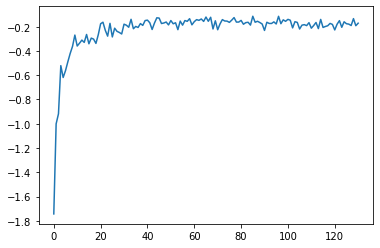

In [77]:
%matplotlib inline

plt.plot(range(len(loss_save)), loss_save)
plt.show